<a href="https://colab.research.google.com/github/kamileo96/GNN-Tracking/blob/main/GNN_muonE_combined_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [1]:
!pip uninstall torchvision torchtext torchaudio --yes
!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: torchvision 0.14.1+cu116
Uninstalling torchvision-0.14.1+cu116:
  Successfully uninstalled torchvision-0.14.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Found existing installation: torchaudio 0.13.1+cu116
Uninstalling torchaudio-0.13.1+cu116:
  Successfully uninstalled torchaudio-0.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 1.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fa

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [3]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.11.0+cu113
PyTorch version: None , CUDA version: 11.3


In [4]:
#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
"""
!pip install torch-geometric
!pip install torch-sparse
!pip install torch-scatter"""
# MW corrected

!pip install torch-geometric \
  torch-sparse==0.6.13 \
  torch-scatter==2.0.9 \
  -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 26.1 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=c5d2597c14e14895b348038fc9f4d8743b213e586ccdbef874677efa8950f6fa
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [5]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""

    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers

    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())

    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True,normalize_factor= 1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        self.normalize_factor=normalize_factor
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)
        
        # Encode the graph features into the hidden space
        #print( torch.mean (data.x[:,0]) )
        #print( torch.mean (data.x[:,1]) )
        if self.normalize_factor!=1:
          temp = data.x.clone().detach()
          temp[:,1] *= self.normalize_factor
          x = self.node_encoder(temp)
        else:
          x = self.node_encoder(data.x.clone().detach())
        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

### Training

In [7]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [8]:
!git clone https://github.com/kamileo96/GNN-Tracking.git
path = '/content/GNN-Tracking/data/'
#Only small and medium files!

Cloning into 'GNN-Tracking'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 61 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), 8.05 MiB | 3.72 MiB/s, done.


In [9]:
gdrive=False
if gdrive:
  from google.colab import drive
  drive.mount('/content/drive/')
  path = '/content/drive/My Drive/MuonE_tracking/'

In [10]:
import numpy as np, pandas as pd
from torch_geometric.data import Data
from torch_geometric.data import DataLoader



#this is what we multiply all inputs by
feature_scale = 1/200
#this is the expected z/x or z/y ratio, that we need to correct when running the GNN
norm_factor = 2000
#                         z scale, x or y scale
feature_scaling = np.array([feature_scale, feature_scale*norm_factor])

#so now our inputs (data.x) should be roughly the same magintudes
#thus the normalize_factor option in the GNN will be set to 1
#we will use the feature scaling again when comparing with real data, this should provide a better 3D line fit

def gen_edges(new_df):
  df = new_df.groupby('layerIndex')
  group_names = list(df.groups.keys())
  # iterate over two consecutive layers
  edges = []
  y = []
  for i in range(len(group_names) - 1):
    layer1 = df.get_group(group_names[i])
    layer2 = df.get_group(group_names[i + 1])
    for _, hit1 in layer1.iterrows():
      for _, hit2 in layer2.iterrows():
        edges.append([hit1.newIndex, hit2.newIndex])

        #this assumes only 1 particle of each ID
        edgeTruthValue = hit1.trackID == hit2.trackID #or (hit1.trackID == 0 and hit2.trackID in [1, 2]) #to connect 0 with 1 and 2 (bad idea)

        #option to classify edges between hits other than 0, 1, 2
        classifyNoise = True
        if not classifyNoise and edgeTruthValue:
          edgeTruthValue = hit1.trackID in [0, 1, 2]
        y.append(int(edgeTruthValue))
  return np.transpose(edges).astype(int), y

def gen_edges_faster(df):
  #by chatGPT :)
  #this returns edges in format [[from][to]] and y
  # Group the dataframe by layerIndex
  groups = df.groupby('layerIndex')
  
  # Extract the indices and track IDs of each group
  indices = [group['newIndex'].values for _, group in groups]
  track_ids = [group['trackID'].values for _, group in groups]

  # Get the number of groups
  n_groups = len(groups)

  # Create an array to hold the edges
  n_edges = sum(len(indices[i]) * len(indices[i+1]) for i in range(n_groups - 1))
  edges = np.empty((2, n_edges), dtype=int)

  # Create an array to hold the matches
  #this will be the y vector
  matches = np.zeros(n_edges, dtype=int)

  # Loop over each pair of adjacent layers
  edge_index = 0
  for i in range(n_groups - 1):
    # Get the indices and track IDs of the two layers
    layer1_indices, layer2_indices = indices[i], indices[i+1]
    layer1_track_ids, layer2_track_ids = track_ids[i], track_ids[i+1]

    # Generate the edges between the two layers
    
    layer1_indices_repeated = np.repeat(layer1_indices, len(layer2_indices))
    layer2_indices_tiled = np.tile(layer2_indices, (len(layer1_indices)))
    edges[:, edge_index:edge_index + len(layer1_indices) * len(layer2_indices)] = np.stack([layer1_indices_repeated, layer2_indices_tiled])
    
    #calculate y
    layer1_trackID_repeated = np.repeat(layer1_track_ids, len(layer2_indices))
    layer2_trackID_tiled = np.tile(layer2_track_ids, (len(layer1_indices)))
    matches_slice = layer1_trackID_repeated == layer2_trackID_tiled
    matches[edge_index:edge_index + len(layer1_indices) * len(layer2_indices)] = matches_slice.flatten()


    # Update the edge index
    edge_index += len(layer1_indices) * len(layer2_indices)

  #shuffle the edges
  shuffle = True
  if shuffle:
    neidx = np.arange(n_edges)
    np.random.shuffle(neidx)
    edges[0] = edges[0][neidx]
    edges[1] = edges[1][neidx]
    matches = matches[neidx]
  return edges, matches


def gen2D_event_data(event):
  neidx = np.arange(len(event))
  #np.random.shuffle(neidx)
  new_df = event.copy()
  new_df['newIndex'] = neidx
  new_df = new_df.sort_values('newIndex')

  edge_index, y = gen_edges_faster(new_df)

  x = new_df[['layerZ', 'hitPos']].values * feature_scaling
  #edge_index = np.transpose(edges).astype(int)
  y = np.array(y)

  #for debug:
  nev = event.iloc[0,0]
  #combining into Data:
  event_data = Data(x = torch.from_numpy(x).float(), edge_index = torch.from_numpy(edge_index), y = torch.from_numpy(y), nevent = nev)
  return event_data

def LoadHitFile(event_file, isX=True):
  #this has to match the data file
  if isX:
    hitType = 0
  else:
    hitType = 1
  
  data = pd.read_csv(event_file)
  data.rename(columns=lambda x: x.strip(), inplace=True)

  #option to remove praticles with ID other than 0,1,2 from dataset
  removeNoise = True
  if removeNoise:
    data = data[data['trackID'].isin([0, 1, 2])]
  #tensors with x as points, edge_index as edges, y as edges values and nevent to track nEvent after shuffling (debug)
  event_data_list_x = []
  event_data_list_y = []
  #lists of small data frames containing full information from hit types 2 , 3 for each nEvent
  stereo2_list = []
  stereo3_list = []
  for num, event in data.groupby(data['nEvent']):
    grouped_data = event.groupby('hitType')
    group_names = list(grouped_data.groups.keys())
    eventx = grouped_data.get_group(0)
    eventy = grouped_data.get_group(1)
    stereo2 = grouped_data.get_group(2)
    stereo3 = grouped_data.get_group(3)
    temp = []
    try:
      temp.append(gen2D_event_data(eventx))
      temp.append(gen2D_event_data(eventy))
      temp.append(stereo2)
      temp.append(stereo3)
      #this prevents adding an event that could be generated in X but not in Y, or reverse
      event_data_list_x.append(temp[0])
      event_data_list_y.append(temp[1])
      stereo2_list.append(temp[2])
      stereo3_list.append(temp[3])
    except Exception as e:
      print(f'Event number {num} unusable.')
      print(e)
      pass
  
  return event_data_list_x, event_data_list_y, stereo2_list, stereo3_list

In [11]:
#from GNN_MuonE_v1_Robust_mc-recon_comparison.ipynb
#note - for now this loads all (would not work if some events are unusable)
def readMCtrack(event_file, is_x= True ):

  data = pd.read_csv(event_file) 

  if is_x:
    axis_oi=[4,1]
  else  :
    axis_oi=[5,2]

  temp=data.iat[-1,0]
  track_slopes=torch.zeros(temp,6)

  for k, row in data.iterrows():

    if (data.iat[k,7]==np.array([0,1,2])).any():

      

      if track_slopes.shape[0]< data.iat[k,0]-1 :
        track_slopes=torch.cat([track_slopes,torch.zeros(1,6)],dim=0)
      
      
      track_slopes[data.iat[k,0]-1,data.iat[k,7]*2 ] = data.iat[k,axis_oi[0]]/data.iat[k,6]

      track_slopes[data.iat[k,0]-1,data.iat[k,7]*2+1] =  data.iat[k,axis_oi[1]] - data.iat[k,axis_oi[0]]/data.iat[k,6]  * data.iat[k,3]
  
  return track_slopes










# Reads From Reconstruction File

def ReadRecon(event_file,is_x=True):
  data = pd.read_csv(event_file)  

  if is_x:
    axis_oi=[3,1,7,5,9]
  else:
    axis_oi=[4,2,8,6,9]

  track_=torch.zeros(data.iat[-1,0],10)

  for k,row in enumerate(data.iterrows()):

    if k % 2 ==0:
      #track_[data.iat[k,0]-1,0],track_[data.iat[k,0]-1,1]=data.iat[k,axis_oi[0]],data.iat[k,axis_oi[1]]
      for i in range( len(axis_oi) ):
        track_[data.iat[k,0]-1,i]=data.iat[k,axis_oi[i]]
    else:
      #track_[data.iat[k,0]-1 ,2],track_[data.iat[k,0]-1,3]=data.iat[k,axis_oi[0]],data.iat[k,axis_oi[1]]
      for i in range( len(axis_oi) ):
        track_[data.iat[k,0]-1,i+5]=data.iat[k,axis_oi[i]]
  

  temp=track_.clone()
  for i in range(data.iat[-1,0]):
    if torch.abs(temp[i,0])>torch.abs(temp[i,5]):

      track_[i,0:4]=temp[i,5:9]
      track_[i,5:9]=temp[i,0:4]



  return track_

In [12]:
def plot_toy_graph(event, ylim=0.):
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    if (ylim!=0):
       plt.ylim(-ylim,ylim)
    else:
       diff = 0.1*(max(y)-min(y))
       plt.ylim(min(y)-diff, max(y)+diff)   

In [13]:
size = 'small'
#size = 'medium'
filename = f'hitFile_{size}.csv'
filename_MC = f"MCtrackFile_{size}.csv"
filename_recon = f"trackFile_{size}.csv"
path = '/content/GNN-Tracking/data/'
#path = '/content/drive/My Drive/MuonE_tracking/'
event_file= path + filename
event_file_MC = path + filename_MC
event_file_recon = path + filename_recon

In [14]:
is_x = True
is_y = False
axis = is_x

Tracks=readMCtrack(event_file_MC,axis)
dataset_tuple = LoadHitFile(event_file,axis)
Tracks_recon=ReadRecon(event_file_recon,axis)

In [15]:
from sklearn.model_selection import train_test_split


train_datasetx,test_datasetx, train_datasety,test_datasety, train_stereo2,test_stereo2,train_stereo3,test_stereo3,test_tracks,train_tracks,train_recon,test_recon = train_test_split(*dataset_tuple, Tracks, Tracks_recon,  test_size=0.2, random_state=42)

#here we define what to train and validate on
train_dataset = train_datasetx
test_dataset = test_datasetx
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


     nEvent        hitPos  hitType  layerZ  layerIndex  trackID
774      30  5.453560e-08        0   -21.0           1        0
776      30  1.479660e-03        0   151.0           3        0
778      30  7.048970e-03        0   497.0           5        0
781      30  7.681080e+00        0   843.7           7        2
782      30 -6.878740e-02        0   843.7           7        1
785      30  1.533060e+01        0  1141.0           9        2
786      30 -1.363250e-01        0  1141.0           9        1
789      30  1.862590e+01        0  1266.0          11        2
790      30 -1.647920e-01        0  1266.0          11        1
797      30  3.749470e+01        0  1960.0          15        2
798      30 -3.219850e-01        0  1960.0          15        1
tensor([[-1.0500e-01,  5.4536e-07],
        [ 7.5500e-01,  1.4797e-02],
        [ 2.4850e+00,  7.0490e-02],
        [ 4.2185e+00,  7.6811e+01],
        [ 4.2185e+00, -6.8787e-01],
        [ 5.7050e+00,  1.5331e+02],
        [ 5.7050

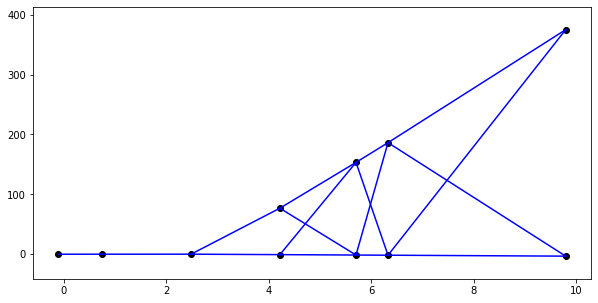

In [16]:
data = pd.read_csv(event_file)
data.rename(columns=lambda x: x.strip(), inplace=True)

data = data[data['hitType'] == 0]
removeNoise = True
if removeNoise:
  data = data[data['trackID'].isin([0, 1, 2])]
event = data[data['nEvent'] == 30]
print(event)
d = gen2D_event_data(event)
print(d.x,
d.edge_index,
d.y,
d.nevent)
plot_toy_graph(d, 0.)

tensor([[-1.0500e-01, -5.7287e-07],
        [ 7.5500e-01, -5.4629e-03],
        [ 2.4850e+00, -1.1235e-03],
        [ 4.2185e+00,  2.9355e+01],
        [ 4.2185e+00, -1.8883e+00],
        [ 5.7050e+00,  5.7161e+01],
        [ 5.7050e+00, -3.7374e+00],
        [ 6.3300e+00,  6.9052e+01],
        [ 6.3300e+00, -4.5121e+00],
        [ 9.8000e+00,  1.3407e+02],
        [ 9.8000e+00, -8.7449e+00]])
Fake / True =  1.0
Training dataset (events):  800
Test dataset (events):  200


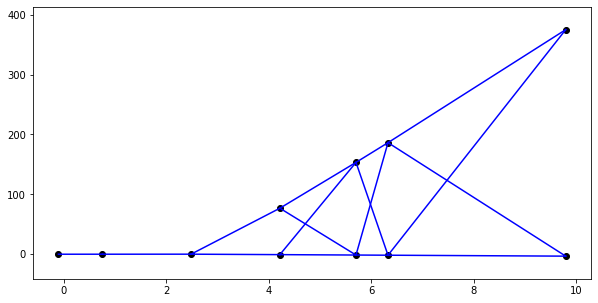

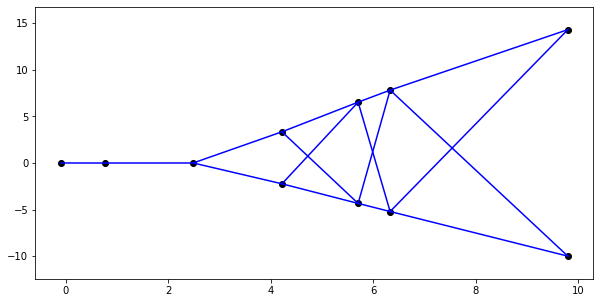

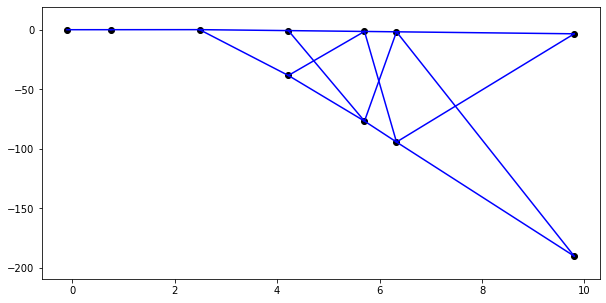

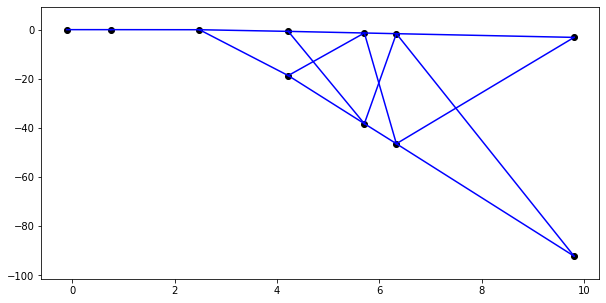

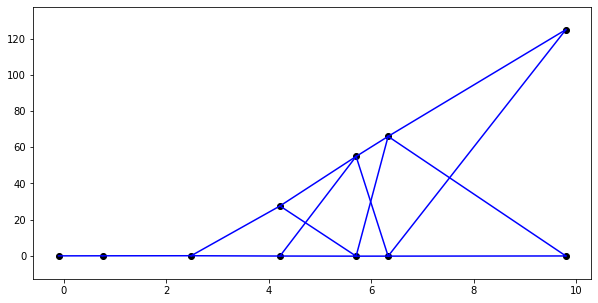

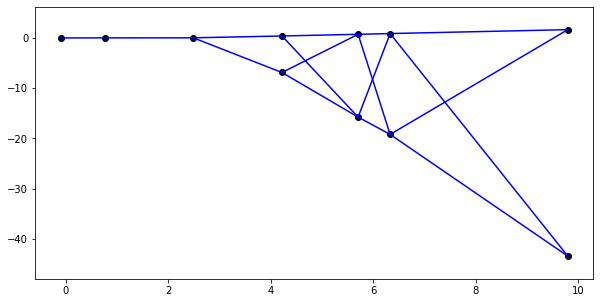

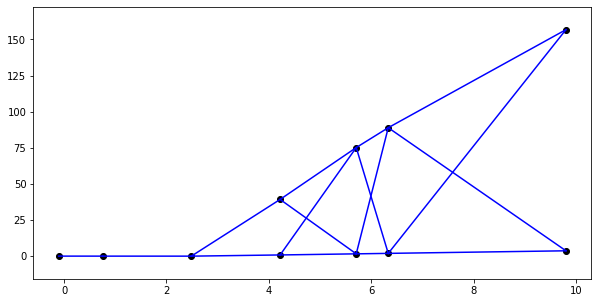

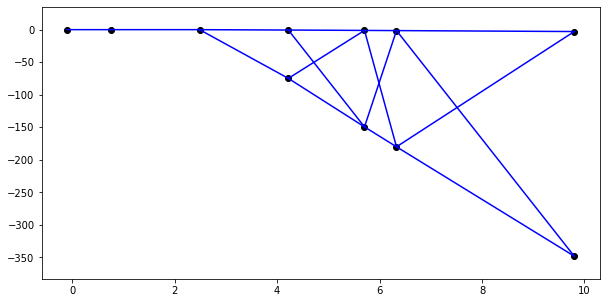

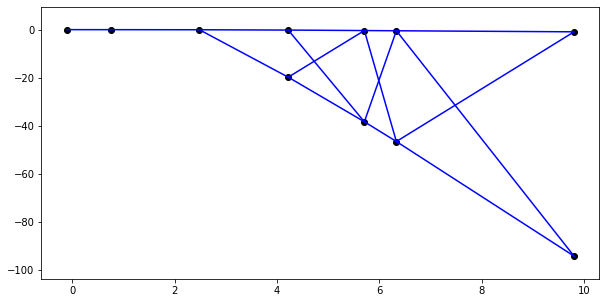

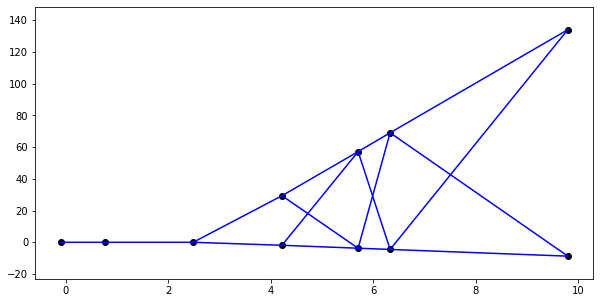

In [17]:
# Display few events
for k in range(0, 10):
   plot_toy_graph(train_loader.dataset[k], 0.)

print(train_loader.dataset[k].x)

print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

In [18]:
print(train_dataset[0].x, train_dataset[0].nevent)

tensor([[-1.0500e-01,  5.4536e-07],
        [ 7.5500e-01,  1.4797e-02],
        [ 2.4850e+00,  7.0490e-02],
        [ 4.2185e+00,  7.6811e+01],
        [ 4.2185e+00, -6.8787e-01],
        [ 5.7050e+00,  1.5331e+02],
        [ 5.7050e+00, -1.3633e+00],
        [ 6.3300e+00,  1.8626e+02],
        [ 6.3300e+00, -1.6479e+00],
        [ 9.8000e+00,  3.7495e+02],
        [ 9.8000e+00, -3.2199e+00]]) 30


In [19]:
weight = ((len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("True / Fake = ", 1/weight)
print("Fake / True = ", weight)

True / Fake =  1.0
Fake / True =  1.0


In [20]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = 1

#device = torch.device('cpu')

#normalize_factor = 1 -> see norm_factor definition
m_configs = {'normalize_factor': 1 ,"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

#m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
#model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

for epoch in range(20):
    ep += 1  
    model.train()
    acc_t, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc_t)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)
    if ep % 10 == 1 or True :
      print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc,acc_t))


Epoch: 1, Accuracy: 0.7070
Epoch: 2, Accuracy: 0.6407
Epoch: 3, Accuracy: 0.7761
Epoch: 4, Accuracy: 0.8052
Epoch: 5, Accuracy: 0.9078
Epoch: 6, Accuracy: 0.9509
Epoch: 7, Accuracy: 0.9662
Epoch: 8, Accuracy: 0.9775
Epoch: 9, Accuracy: 0.9853
Epoch: 10, Accuracy: 0.9887
Epoch: 11, Accuracy: 0.9894
Epoch: 12, Accuracy: 0.9909
Epoch: 13, Accuracy: 0.9919
Epoch: 14, Accuracy: 0.9931
Epoch: 15, Accuracy: 0.9937
Epoch: 16, Accuracy: 0.9944
Epoch: 17, Accuracy: 0.9947
Epoch: 18, Accuracy: 0.9950
Epoch: 19, Accuracy: 0.9953
Epoch: 20, Accuracy: 0.9959


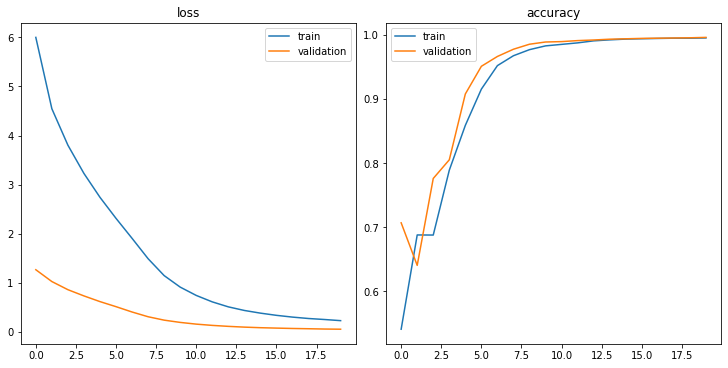

In [21]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].set_title("loss")
axs[0].set_yscale("linear")
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label='train')
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label='validation')
axs[0].legend()

axs[1].set_title("accuracy")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label='train')
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label='validation')
axs[1].legend()
axs[1].set_yscale("linear")

In [22]:
def plot_toy_classified(event, preds, cut=0.5):
    
    #print("New event")
        
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)
    #gprint(preds)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    plt.title(event.nevent)
    preds = preds.detach().numpy()
    

    for j in range(len(labels)):
        
        #print(str('%01.2f' % preds[j])+" "+str(labels[j].item())+" "+str(x[edges[0,j]]*feature_scale)+","+str(y[edges[0,j]]*feature_scale)+" "+str(x[edges[1,j]]*feature_scale)+","+str(y[edges[1,j]]*feature_scale))
        s = str('%01.2f' % preds[j])+" "+str(labels[j].item())
        plt.text((x[edges[0,j]]+x[edges[1,j]])/2., (y[edges[0,j]]+y[edges[1,j]])/2.+np.random.random(1)*0.00, s, fontsize=12)

        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

In [23]:
def full_acc(test_loader):
  corr = 0
  for k in range(len(test_loader.dataset)):
    data = test_loader.dataset[k].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    cut = 0.6
    corr += int(np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()))
  return(corr/len(test_loader.dataset))

In [24]:
full_acc(test_loader)

0.97

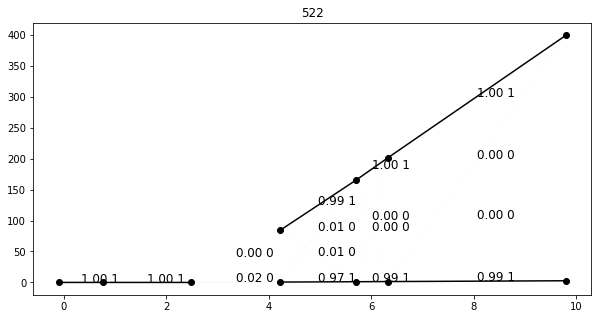

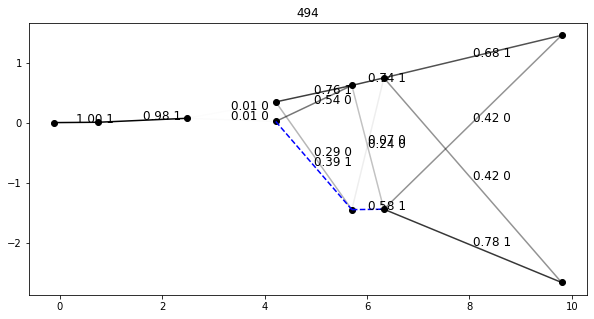

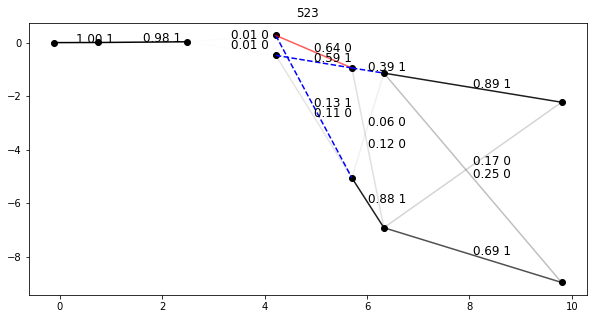

In [25]:
for k in range(100):
   data = test_loader.dataset[k].to(device)
   preds = torch.sigmoid(model(data)).to('cpu')
   cut = 0.6
   if not np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()) or k == 0:
     plot_toy_classified(data.to('cpu'), preds, cut = cut)

In [26]:
from scipy.optimize import minimize

#from tracking 2022
def finder(data,y,cut=0.5):
  x = data.x.clone().numpy()
  edge_index=data.edge_index.detach().numpy()
  node_identifier=np.zeros( list(x.shape)[0] )
  k=edge_index.shape[1]
  y=y.detach().tolist()
  is_connected=[]
  for i in range(k):
    if y[i]-cut>=0:
      is_connected.append( True )
    else:
      is_connected.append( False )

  for j in range(1,4):

    a=np.where( node_identifier==0 )
    if j==1:
      try:
        min=np.min(np.abs(x[a,0]))
      except:
        print('oopsie')
        break
      idx=np.where(np.abs(x[:,0])==min)
    

    else:
      try:
        min=np.min(np.abs(x[a,1]))
      except:
        print('oopsie')
        break
      idx=np.where(np.abs(x[:,1])==min)
    
    try:
      idx=idx[0]
    except:
      pass
    
    neighbor = 1
    node_identifier[idx] = j
    
    
    while neighbor :

      neighbor = []
      try:
        idx=idx[-1]
      except:
        pass
      in_neighbor = [ int(edge_index[0,i]) for i in range(k) if int(edge_index[1,i])==idx if is_connected[i] 
                     if node_identifier[ edge_index[0,i] ] ==0  ]

      ot_neighbor = [ int(edge_index[1,i]) for i in range(k) if int(edge_index[0,i])==idx if is_connected[i] 
                     if node_identifier[ edge_index[1,i] ] ==0  ]
      neighbor = in_neighbor + ot_neighbor
      
      if len(neighbor)>0:
        for i in reversed( range( len(neighbor) ) ):
          if node_identifier[neighbor[i]] != 0 :
            del neighbor[i]
      

      if neighbor:
        idx=neighbor[0]

      node_identifier[neighbor] = j



  return node_identifier





def fit(x,a,b): 
  return a*x+b
def chi2(x,y,yerr,fit,popt):
  # Now calculate chi square 
  yexp = fit(x, *popt)
  r_ = (y - yexp)/yerr
  chisq_ = np.sum(r_**2)
  df_ = len(x) - 2
  return chisq_, df_, r_

def distance_sqr(theta, z, d, c, s):
  x0, y0, Ax, Ay = theta
  z0 = 0.
  Az = np.sqrt(1 - Ax**2 - Ay**2)
  
  # define point on line 1
  P1 = np.array([x0, y0, z0])   
  # define direction vector for line 1
  V1 = np.array([Ax, Ay, Az])
  
  #important note:
  #phi is defined by the axis of measurement. But the actual strip lines are perpendicular to this axis, ie:
  #phi = 0 is detection of x position. But actually, the strips are then along the y axis.
  #this is reflected in the calculations of P2 and V2

  # define point on line 2
  P2 = np.array([d*c, d*s, z])
  # define direction vector for line 2
  V2 = np.array([s, -c, 0])

  diff = P2 - P1
  cross = np.cross(V1, V2)
  return np.dot(diff, cross)**2 / np.dot(cross, cross)

def objective(theta, zs, ds, cs, ss):
  g = 0
  for z,d,c,s in zip(zs,ds,cs,ss):
    g += distance_sqr(theta, z, d, c, s)
  return g


def line_fit_3D(zs, ds, phis, theta0=np.array([0., 0., 0., 0.])):
  #input is same-length arrays containing information on the strips z, distance from 0 and angle between x axis

  #x0, y0, Ax, Ay (z0=0, Az = sqrt(1-Ax^2-Ay^2))
  #theta0 = np.array([0., 0., 0., 0.])

  #to not repeat these calculations:
  cs = np.cos(phis)
  ss = np.sin(phis)
  
  #here we should either implement the constraint for Ax^2+Ay^2 < 1
  #or change the optimization parameter entirely, ie into x0,y0,theta,phi
  opt = minimize(objective, theta0, args=(zs, ds, cs, ss), method='L-BFGS-B')
  if not opt.success:
    print('Error: line fit failed')
  theta_opt = opt.x
  return theta_opt
    
    

def robust_fit3D(datax, predsx, datay, predsy, stereo2, stereo3):
  zs, ds, phis = np.array([]), np.array([]), np.array([])

  #choose if we want to fit using rescaled or rescaled_back (original) positions
  rescale_back = True
  #right now we need to rescale back, because line fit works when Ax,Ay << Az
  if rescale_back:
    fsc = feature_scaling
  else:
    fsc = np.array([1.,1.])

  #we generate two sets of data for each axis (4 total). We then will need to find the right combination using stereo layers
  zx, x = datax.x[:,0].clone().numpy()/fsc[0],datax.x[:,1].clone().numpy()/fsc[1]
  node_lines_x = finder(datax,predsx)
  zx_list = [zx[np.where(node_lines_x==i)] for i in [2,3]]
  x_list = [x[np.where(node_lines_x==i)] for i in [2,3]]

  zy, y = datay.x[:,0].clone().numpy()/fsc[0],datay.x[:,1].clone().numpy()/fsc[1]
  node_lines_y = finder(datay,predsy)
  zy_list = [zy[np.where(node_lines_y==i)] for i in [2,3]]
  y_list = [y[np.where(node_lines_y==i)] for i in [2,3]]

  stereo_layers = []
  num_stereo = 0
  for _, layer in stereo2.groupby(stereo2['layerIndex']):
    stereo_layers.append([layer['layerZ'].values * feature_scaling[0]/fsc[0], layer['hitPos'].values * feature_scaling[1]/fsc[1], np.ones(len(layer.index))*np.pi/4])
    num_stereo += len(layer.index)
  
  for _, layer in stereo3.groupby(stereo3['layerIndex']):
    stereo_layers.append([layer['layerZ'].values * feature_scaling[0]/fsc[0], layer['hitPos'].values * feature_scaling[1]/fsc[1], np.ones(len(layer.index))*(-np.pi/4)])
    num_stereo += len(layer.index)
  #we try four combinations:
  #this is a lot of nested loops! but most of them should be length 2
  #(thus this approach is not suitable for more than 2 tracks)
  scores = []
  tracks = []

  stereo_colors = np.zeros((4, num_stereo), dtype=int)
  for i1 in range(2):
    for i2 in range(2):
      zs = np.append(zx_list[i1], zy_list[i2])
      ds = np.append(x_list[i1], y_list[i2])
      phis = np.append(np.zeros(len(x_list[i1])), np.ones(len(y_list[i2]))*np.pi/2)
      track_theta = line_fit_3D(zs, ds, phis)
      stereo_distance = []
      stereo_idx = 0
      for layer in stereo_layers:
        distances = []
        for z,d,c,s in zip(layer[0], layer[1], np.cos(layer[2]), np.sin(layer[2])):
          distances.append(distance_sqr(track_theta, z,d,c,s))
        #for now two tracks can use the same stereo layer
        mind = min(distances)
        stereo_distance.append(mind)
        #
        stereo_colors[i1*2+i2, stereo_idx + distances.index(mind)] = 1
        stereo_idx += len(distances)
      
      scores.append(np.sum(stereo_distance))
      tracks.append(track_theta)
  #he have created all possible tracks and checked their distance from stereo hits.
  #now we need to pick the pair that has the lowest sum:

  #pair 1:
  score1 = scores[0] + scores[3] #for now sum, maybe max?
  #pair 2:
  score2 = scores[1] + scores[2]

  if score1 < score2: 
    #here we could add muon/electron differentiation
    i1s = np.array([0, 0])
    i2s = np.array([1, 1])
  else:
    i1s = np.array([0, 1])
    i2s = np.array([1, 0])

  idx1 = i1s[0] + 2*i1s[1]
  idx2 = i2s[0] + 2*i2s[1]


  track1 = tracks[idx1]
  track2 = tracks[idx2]
  stc1 = stereo_colors[idx1]
  stc2 = stereo_colors[idx2]

  #here we could re-do the fits, using stereo layers data


  stereo_data = np.concatenate(stereo_layers, axis=1)
  z = np.concatenate((zx, zy, stereo_data[0]))
  d = np.concatenate((x,y, stereo_data[1]))
  phi = np.concatenate((np.zeros(len(x)), np.ones(len(y))*np.pi/2, stereo_data[2]))

  #color:
  #0 - muon before col
  #1 - track 1 or type1 hit
  #2 - track 2 or type2 hit
  #3 - other than type2
  #4 - ghost hit (stereo)
  #5 - double hit (track1 and 2), for stereo

  #+2 because color 1 is reserved for muon before colision in node_lines
  colorx = (node_lines_x == (i1s[0]+2))*1 + (node_lines_x == (i2s[1]+2))*2 + (node_lines_x > 3)*3 #0 stays 0
  colory = (node_lines_y == (i1s[0]+2))*1 + (node_lines_y == (i2s[1]+2))*2 + (node_lines_y > 3)*3 #0 stays 0
  #we have two arrays like [0, 0, 1, 0, ...] and want to get 4 if both are 0, 1 if 1 in 1st, 2 if 1 in 2nd, 5 if 1 in both
  stc = stc1 + stc2*2
  #now we have either 1, 2, 0 or 3
  stc[stc == 0] = 4
  stc[stc == 3] = 5
  color = np.concatenate((colorx, colory, stc))

  strip_data = [z, d , phi, color]
  #for now i just return the tracks
  return track1, track2, strip_data

In [27]:
import plotly.express as px

def xy_from_phi(phi, d, r):
  x = np.cos(phi)*d + np.sin(phi)*r
  y = np.sin(phi)*d - np.cos(phi)*r
  return x, y
def point_from_theta(z1, theta):
  #Az =/= 0
  x0, y0, Ax, Ay = theta
  z0 = 0.
  Az = np.sqrt(1 - Ax**2 - Ay**2)
  t = (z1 - z0)/Az
  x1 = x0 + ((z1 - z0) / Az) * Ax
  y1 = y0 + ((z1 - z0) / Az) * Ay
  return x1,y1,z1
def plot_tracks_and_strips(tracks, strip_data, r = 5, zmax=2000, z_hit = 600):
  
  zs, ds, phis, cs = strip_data
  df = pd.DataFrame([], columns=['x', 'y', 'z', 'label', 'color'])
  j=0
  for phi, d, z, c in zip(phis, ds, zs, cs):
    p1 = [*xy_from_phi(phi, d, +r), z, j, c]
    p2 = [*xy_from_phi(phi, d, -r), z, j, c]
    df2 = pd.DataFrame([p1, p2], columns=['x', 'y', 'z', 'label', 'color'])
    df = df.append(df2, ignore_index=True)
    j+=1
  for n,track_theta in enumerate(tracks):
    p2 = [*point_from_theta(z_hit,track_theta), j, 1+n]
    p1 = [*point_from_theta(zmax,track_theta), j, 1+n]
    df2 = pd.DataFrame([p1, p2], columns=['x', 'y', 'z', 'label', 'color'])
    df = df.append(df2, ignore_index=True)
    j+=1
  fig = px.line_3d(df, x='x', y='y', z='z', line_group='label', color='color')
  fig.show()


In [28]:
k = 1
datax = test_datasetx[k]
predsx=torch.sigmoid(model(datax))
datay = test_datasety[k]
predsy=torch.sigmoid(model(datay))
stereo2 = test_stereo2[k]
stereo3 = test_stereo3[k]
print(f'nevent {datax.nevent}')
t1,t2, strip_data = robust_fit3D(datax,predsx, datay, predsy, stereo2, stereo3)
print(t1, t2, strip_data)
plot_tracks_and_strips([t1,t2],strip_data)

nevent 738
[-0.05721513  0.08205853  0.00011035 -0.00016827] [ 11.48268552 -13.20385336  -0.02076964   0.02459625] [array([ -21.        ,  151.        ,  497.        ,  843.70007324,
        843.70007324, 1141.        , 1141.        , 1266.        ,
       1266.        , 1960.00012207, 1960.00012207,  -16.        ,
        131.        ,  477.        ,  832.        ,  832.        ,
       1146.        , 1146.        , 1479.59997559, 1479.59997559,
       1973.        , 1973.        , 1252.7       , 1252.7       ,
       1467.4       , 1467.4       ]), array([ 3.72568991e-07, -7.33633002e-04,  2.69602006e-03, -6.08995008e+00,
        3.70059013e-02, -1.22823000e+01,  6.79602996e-02, -1.48076000e+01,
        8.21336955e-02, -2.92092991e+01,  1.59263998e-01,  1.32538000e-04,
        3.52564012e-03,  1.14795994e-02,  7.30378056e+00, -5.55527993e-02,
        1.48675003e+01, -1.12606004e-01,  2.32131996e+01, -1.68771997e-01,
        3.54075012e+01, -2.48469993e-01,  2.10175000e+00, -3.5541900

In [29]:
zs = np.array([0., 1., 2.])
ds = np.array([0., 0.5, 1.])
phis = np.array([0., np.pi/2, np.pi/4])

theta_good = np.array([0., 0., 1/np.sqrt(3), 0.])
theta0 = theta_good
#theta0 = np.zeros(4)

theta = line_fit_3D(zs, ds, phis, theta0=theta0)
strip_data = [zs,ds,phis,np.zeros(len(zs))]

print(theta)
print(point_from_theta(2., theta))
print([distance_sqr(theta, zs[i], ds[i], np.cos(phis[i]), np.sin(phis[i])) for i in range(len(zs))])
print(objective(theta, zs, ds, np.cos(phis), np.sin(phis)))

print(theta_good)
print(point_from_theta(2., theta_good))
print([distance_sqr(theta_good, zs[i], ds[i], np.cos(phis[i]), np.sin(phis[i])) for i in range(len(zs))])
print(objective(theta_good, zs, ds, np.cos(phis), np.sin(phis)))
plot_tracks_and_strips([theta],strip_data, z_hit=-0.2, zmax=3.2, r=2.5)

[2.92601481e-07 2.74445435e-01 3.18409083e-01 2.08575314e-01]
(0.6886588444107331, 0.7255543419776918, 2.0)
[7.654075206784027e-14, 1.1798078147028703e-14, 6.080800526949328e-14]
1.4914683548436226e-13
[0.         0.         0.57735027 0.        ]
(1.4142135623730954, 0.0, 2.0)
[0.0, 0.24999999999999992, 1.3312027775604575e-31]
0.24999999999999992


In [30]:
zs = np.array([-0.1, 0.1, 2.-0.1, 2.+0.1])
ds = np.array([0.2, 0.5, 0.7, 1.2])
phis = np.array([np.pi/4., np.pi/2, 0., -np.pi/4])

#theta_good = np.array([0., 0., 1/np.sqrt(3), 0.])
#theta0 = theta_good
theta0 = np.zeros(4)

theta = line_fit_3D(zs, ds, phis, theta0=theta0)
strip_data = [zs,ds,phis,np.zeros(len(zs))]

print(theta)
print(point_from_theta(2., theta))
print([distance_sqr(theta, zs[i], ds[i], np.cos(phis[i]), np.sin(phis[i])) for i in range(len(zs))])
print(objective(theta, zs, ds, np.cos(phis), np.sin(phis)))

print(theta_good)
print(point_from_theta(2., theta_good))
print([distance_sqr(theta_good, zs[i], ds[i], np.cos(phis[i]), np.sin(phis[i])) for i in range(len(zs))])
print(objective(theta_good, zs, ds, np.cos(phis), np.sin(phis)))
plot_tracks_and_strips([theta],strip_data, z_hit=-0.2, zmax=3.2, r=2.5)

[-0.30348153  0.56956007  0.39777368 -0.52397174]
(0.7528167002014019, -0.8218603618600532, 2.0)
[3.201344246408057e-11, 8.076388863876997e-11, 2.5016883537001674e-12, 1.2912276387318636e-11]
1.2819129584386935e-10
[0.         0.         0.57735027 0.        ]
(1.4142135623730954, 0.0, 2.0)
[0.05, 0.25, 0.2760639746958559, 0.017999999999999895]
0.5940639746958558


In [31]:
data = pd.read_csv(event_file)
data.rename(columns=lambda x: x.strip(), inplace=True)

event = data[data['nEvent'] == 738]
event = event[event['trackID'] == 2]
event = event[event['hitType'].isin([0, 1])]
print(event)

zs = event['layerZ'].values#*feature_scaling[0]
ds = event['hitPos'].values#*feature_scaling[1]

hitType_phi = np.array([0, np.pi/2, np.pi/4, -np.pi/4])
phis = hitType_phi[event['hitType'].to_numpy(dtype=int)]


#theta_good = np.array([0., 0., -0.707, 0.707])
#theta0 = theta_good
#theta0 = np.zeros(4)

theta = line_fit_3D(zs, ds, phis, theta0=theta0)
strip_data = [zs,ds,phis,np.zeros(len(zs))]

print(theta)
print(point_from_theta(2., theta))
print([distance_sqr(theta, zs[i], ds[i], np.cos(phis[i]), np.sin(phis[i])) for i in range(len(zs))])
print(objective(theta, zs, ds, np.cos(phis), np.sin(phis)))

plot_tracks_and_strips([theta],strip_data, z_hit=550, zmax=2000)

       nEvent    hitPos  hitType  layerZ  layerIndex  trackID
19583     738   7.30378        1   832.0           6        2
19585     738  -6.08995        0   843.7           7        2
19587     738  14.86750        1  1146.0           8        2
19589     738 -12.28230        0  1141.0           9        2
19593     738 -14.80760        0  1266.0          11        2
19595     738  23.21320        1  1479.6          12        2
19599     738  35.40750        1  1973.0          14        2
19601     738 -29.20930        0  1960.0          15        2
[ 11.48268519 -13.20385526  -0.02076964   0.02459625]
(11.441124362106537, -13.15463725445663, 2.0)
[0.0010846817568847626, 0.0016154795165970737, 0.0170362680184192, 0.0029728110189753834, 0.00031372897669734696, 3.104969163934786e-05, 0.003337854743417223, 0.0014148073962824456]
0.027806681118912786
